## 频繁模式与关联规则挖掘
### 问题描述
本次作业中，将选择1个数据集进行频繁模式和关联规则挖掘。
### 数据分析要求  
- 对数据集进行处理，转换成适合进行关联规则挖掘的形式；
- 找出频繁模式；
- 导出关联规则，计算其支持度和置信度;
- 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；  
- 对挖掘结果进行分析；  
- 可视化展示。  

### 代码仓库
https://github.com/lalalamdbf/Datamining

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

### 1. 数据集处理（数据集为Wine Reviews）

In [5]:
#对数据集进行合并
data1 = pd.read_csv("Wine Reviews/winemag-data_first150k.csv", encoding="utf-8")
data2 = pd.read_csv("Wine Reviews/winemag-data-130k-v2.csv", encoding="utf-8")
columns=["country", "description", "designation", "points", "price", 
               "province", "region_1", "region_2","variety","winery"]
data1 = data1[columns]
data2 = data2[columns]
data_all = pd.concat([data1, data2],axis=0)
# 去除有缺失值的数据
data_all = data_all.dropna(how='any')
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73325 entries, 0 to 129950
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      73325 non-null  object 
 1   description  73325 non-null  object 
 2   designation  73325 non-null  object 
 3   points       73325 non-null  int64  
 4   price        73325 non-null  float64
 5   province     73325 non-null  object 
 6   region_1     73325 non-null  object 
 7   region_2     73325 non-null  object 
 8   variety      73325 non-null  object 
 9   winery       73325 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 6.2+ MB
None


### 2. 关联规则挖掘
- 采用Apriori算法发现频繁项集
- 关联规则,计算其支持度和置信度,采用Lift和Jaccard进行评估

In [6]:
from tqdm import tqdm
from progressbar import *

class Association(object):
    #首先找出所有频繁项集,然后由频繁项集产生强关联规则
    def __init__(self, min_support = 0.1, min_confidence = 0.5):
        self.min_support = min_support         # 最小支持度
        self.min_confidence = min_confidence   #  最小置信度

    def apriori(self, dataset):
        """
        Apriori algorithm
        dataset:数据集,类型为一个list,list中每个元素是一个dict,key为属性名,value为对应属性的取值
        返回生成的频繁项集
        """
        C1 = self.create_C1(dataset)
        dataset = [set(data) for data in dataset]
        L1, support_data = self.scan_D(dataset, C1)
        L = [L1]
        k = 2
        while len(L[k-2]) > 0:
            Ck = self.apriori_gen(L[k-2], k)
            Lk, support_k = self.scan_D(dataset, Ck)
            support_data.update(support_k)
            L.append(Lk)
            k += 1
        return L, support_data

    def create_C1(self, dataset):
        """
        构建全部可能的单元素候选项集合(list)
        每个单元素候选项：（属性名,属性取值）
        """
        C1 = []
        progress = ProgressBar()
        for data in progress(dataset):
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        return [frozenset(item) for item in C1]

    def scan_D(self, dataset, Ck):
        """
        根据待选项集Ck的情况,判断数据集D中Ck元素的出现频率
        过滤掉低于最小支持度的项集
        """
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        support_data = dict()
        # 过滤非频繁项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_support:
                return_list.insert(0, key)
            support_data[key] = support
        return return_list, support_data

    def apriori_gen(self, Lk, k):
        #合并元素时容易出现重复,针对包含k个元素的频繁项集,对比每个频繁项集第k-2位是否一致
        return_list = []
        len_Lk = len(Lk)
        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                # 第k-2个项相同时,将两个集合合并
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list

    def generate_rules(self, L, support_data):
        """
        强关联规则
        基于Apriori算法,首先从一个频繁项集开始,接着创建一个规则列表,
        其中规则右部只包含一个元素,然后对这些规则进行测试。
        接下来合并所有的剩余规则列表来创建一个新的规则列表,
        其中规则右部包含两个元素。这种方法称作分级法。
        L: 频繁项集
        support_data: 频繁项集对应的支持度
        返回强关联规则列表
        """
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self.rules_from_conseq(freq_set, H1, support_data, big_rules_list)
                else:
                    self.cal_conf(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

    def rules_from_conseq(self, freq_set, H, support_data, big_rules_list):
        # H->出现在规则右部的元素列表
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self.apriori_gen(H, m+1)
            Hmp1 = self.cal_conf(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                self.rules_from_conseq(freq_set, Hmp1, support_data, big_rules_list)

    def cal_conf(self, freq_set, H, support_data, big_rules_list):
        # 评估生成的规则
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            jaccard = sup / (support_data[freq_set - conseq] + support_data[conseq] - sup)
            if conf >= self.min_confidence:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift,jaccard))
                prunedH.append(conseq)
        return prunedH

def mining(data, min_support = 0.1, min_confidence = 0.5,head_n=None):
        out_path = "./WineResults"
        association = Association(min_support=min_support,min_confidence=min_confidence)
        data_all = data
        rows = None
        if head_n is None:
          rows = data_all.values.tolist()
        else:
          rows = data_all.head(head_n).values.tolist()

        # 将数据转为数据字典存储
        dataset = []
        feature_names = ["country", "description", "designation", "points", "price", 
               "province", "region_1", "region_2","variety","winery"]
        for data_line in rows:
            data_set = []
            for i, value in enumerate(data_line):
                if not value:
                    data_set.append((feature_names[i], 'NA'))
                else:
                    data_set.append((feature_names[i], value))
            dataset.append(data_set)
        print("挖掘开始")
        # 获取频繁项集
        freq_set, sup_rata = association.apriori(dataset)
        sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)
        # 获取强关联规则列表
        strong_rules_list = association.generate_rules(freq_set, sup_rata)
        strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)

        print("挖掘完成！")
        # 将频繁项集输出到结果文件
        freq_set_file = open(os.path.join(out_path, 'fterms.json'), 'w')
        for (key, value) in sup_rata_out:
            result_dict = {'set': None, 'sup': None}
            set_result = list(key)
            sup_result = value
            if sup_result < association.min_support:
                continue
            result_dict['set'] = set_result
            result_dict['sup'] = sup_result
            json_str = json.dumps(result_dict, ensure_ascii=False)
            freq_set_file.write(json_str + '\n')
        freq_set_file.close()

        # 将关联规则输出到结果文件
        rules_file = open(os.path.join(out_path, 'rules.json'), 'w')
        for result in strong_rules_list:
            result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
            X_set, Y_set, sup, conf, lift, jaccard = result
            result_dict['X_set'] = list(X_set)
            result_dict['Y_set'] = list(Y_set)
            result_dict['sup'] = sup
            result_dict['conf'] = conf
            result_dict['lift'] = lift
            result_dict['jaccard'] = jaccard

            json_str = json.dumps(result_dict, ensure_ascii=False)
            rules_file.write(json_str + '\n')
        rules_file.close()
        print("结果存储完成！")
        
mining(data_all, min_support = 0.1, min_confidence = 0.5,head_n=50000)

挖掘开始


100% |########################################################################|


挖掘完成！
结果存储完成！


### 3. 挖掘结果分析
##### 频繁项集按支持度从大到小的排序如下：

In [7]:
with open("WineResults/fterms.json") as f1:
  freq = [json.loads(each) for each in f1.readlines()]
freq

[{'set': [['country', 'US']], 'sup': 1.0},
 {'set': [['province', 'California']], 'sup': 0.71612},
 {'set': [['province', 'California'], ['country', 'US']], 'sup': 0.71612},
 {'set': [['region_2', 'Central Coast']], 'sup': 0.23342},
 {'set': [['province', 'California'], ['region_2', 'Central Coast']],
  'sup': 0.23342},
 {'set': [['country', 'US'], ['region_2', 'Central Coast']], 'sup': 0.23342},
 {'set': [['country', 'US'],
   ['province', 'California'],
   ['region_2', 'Central Coast']],
  'sup': 0.23342},
 {'set': [['region_2', 'Sonoma']], 'sup': 0.19716},
 {'set': [['region_2', 'Sonoma'], ['province', 'California']], 'sup': 0.19716},
 {'set': [['region_2', 'Sonoma'], ['country', 'US']], 'sup': 0.19716},
 {'set': [['province', 'California'],
   ['region_2', 'Sonoma'],
   ['country', 'US']],
  'sup': 0.19716},
 {'set': [['variety', 'Pinot Noir']], 'sup': 0.19056},
 {'set': [['variety', 'Pinot Noir'], ['country', 'US']], 'sup': 0.19056},
 {'set': [['province', 'Washington']], 'sup': 0

##### 关联规则按置信度从大到小排序如下
分析得出points和country、province和country、region_2和province、region_2和country、variety和(country,province)有较高的关联度

In [8]:
with open("WineResults/rules.json") as f2:
  rules = [json.loads(each) for each in f2.readlines()]
rules

[{'X_set': [['points', 87]],
  'Y_set': [['country', 'US']],
  'sup': 0.12466,
  'conf': 1.0,
  'lift': 8.021819348628268,
  'jaccard': 0.12466},
 {'X_set': [['points', 88]],
  'Y_set': [['country', 'US']],
  'sup': 0.1083,
  'conf': 1.0,
  'lift': 9.233610341643583,
  'jaccard': 0.1083},
 {'X_set': [['points', 90]],
  'Y_set': [['country', 'US']],
  'sup': 0.1152,
  'conf': 1.0,
  'lift': 8.680555555555555,
  'jaccard': 0.1152},
 {'X_set': [['province', 'Washington']],
  'Y_set': [['country', 'US']],
  'sup': 0.15882,
  'conf': 1.0,
  'lift': 6.296436217101121,
  'jaccard': 0.15882},
 {'X_set': [['region_2', 'Columbia Valley']],
  'Y_set': [['country', 'US']],
  'sup': 0.15006,
  'conf': 1.0,
  'lift': 6.6640010662401705,
  'jaccard': 0.15006},
 {'X_set': [['region_2', 'Columbia Valley']],
  'Y_set': [['province', 'Washington']],
  'sup': 0.15006,
  'conf': 1.0,
  'lift': 6.6640010662401705,
  'jaccard': 0.9448432187381942},
 {'X_set': [['region_2', 'Central Coast']],
  'Y_set': [['co

### 4. 可视化展示

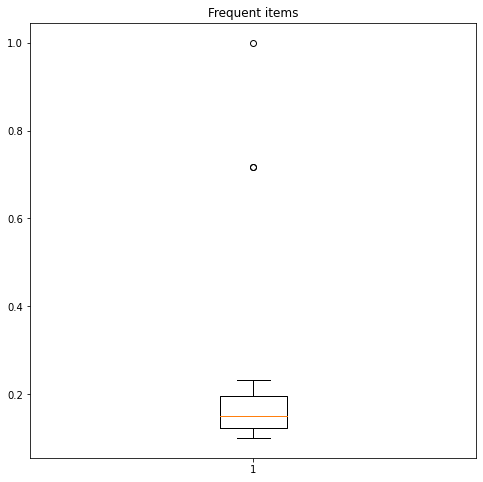

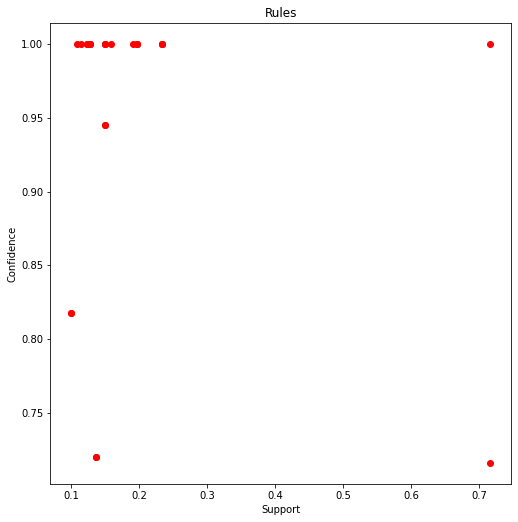

In [9]:

freq_sup = [each["sup"] for each in freq]
plt.figure(figsize=(8,8))
plt.title("Frequent items")
plt.boxplot(freq_sup)
plt.show()


rules_sup = [each["sup"] for each in rules]
rules_conf = [each["conf"] for each in rules]
fig=plt.figure(figsize=(8,8))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
ax.set_title("Rules")
ax.scatter(rules_sup, rules_conf, marker='o', color='red')
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
plt.show()